In [1]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import io
import logging
import pandas as pd
import pandahouse
from read_db.CH import Getch
import os
sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [2]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [3]:
connection = {}

q = """
SELECT distinct user_id
FROM simulator_20220320.feed_actions 
WHERE toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21' 
"""

# Вытащили пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

# Сделали группы
users_df['hash_group'] = users_df.user_id.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

,hash_group,user_id
0,0,10151
1,1,9982
2,2,9977
3,3,9963
4,4,10076


In [4]:
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group, 
    uniqExact(user_id)
FROM simulator_20220320.feed_actions 
WHERE toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21' 
group by group 
"""

pandahouse.read_clickhouse(q, connection=connection)

,group,uniqExact(user_id)
0,0,10091
1,1,9976
2,2,9966
3,3,10140
4,4,9976


In [5]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220320.feed_actions 
WHERE toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21' 
    and exp_group in (3,4)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
3,10049,10049,10049,10049
4,10070,10070,10070,10070


In [6]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,4,136790,47,89,0.528090
2,3,123580,13,48,0.270833
3,4,137010,24,133,0.180451
4,4,27261,13,60,0.216667
...,...,...,...,...,...
20114,3,122008,5,41,0.121951
20115,4,30084,20,116,0.172414
20116,3,122190,19,65,0.292308
20117,4,29778,10,60,0.166667


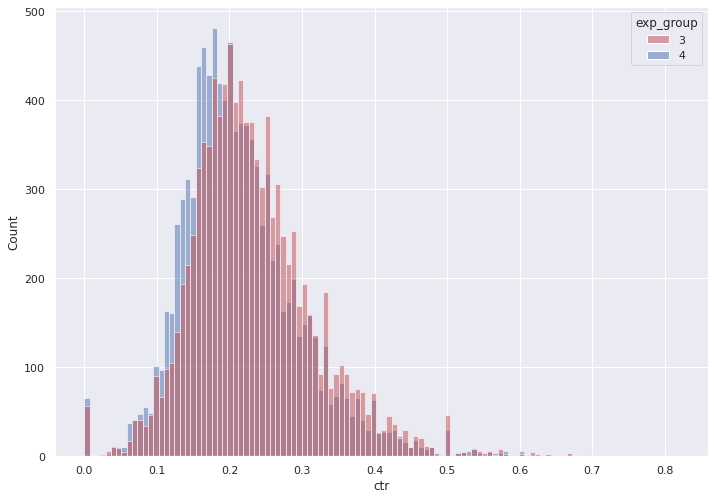

In [7]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [8]:
stats.ttest_ind(df[df.exp_group == 3].ctr,
                df[df.exp_group == 4].ctr,
                equal_var=False)

Ttest_indResult(statistic=13.293114078425628, pvalue=3.75010873627611e-40)

In [9]:
print(stats.mannwhitneyu(df[df.exp_group == 3].ctr,
                df[df.exp_group == 4].ctr))

print('Отличие не прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 3].ctr.sample().values[0] > df[df.exp_group == 4].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=56863830.0, pvalue=2.801374754430791e-52)
Отличие не прокрасилось
В 56.73 % случаев A > B. Должно получиться около 50%


In [10]:
# exp_group = 1 - КОНТРОЛЬ
# exp_group = 2 - NEW


In [11]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220320.feed_actions 
WHERE toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21' 
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#T-тест

stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

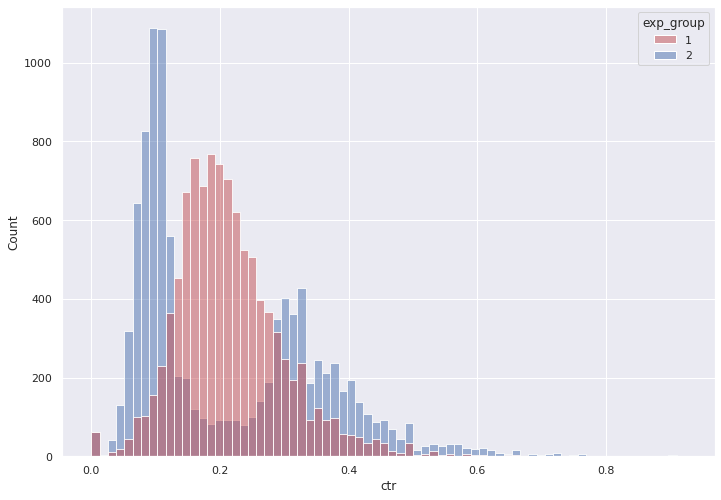

In [12]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [13]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

<AxesSubplot:xlabel='ctr'>

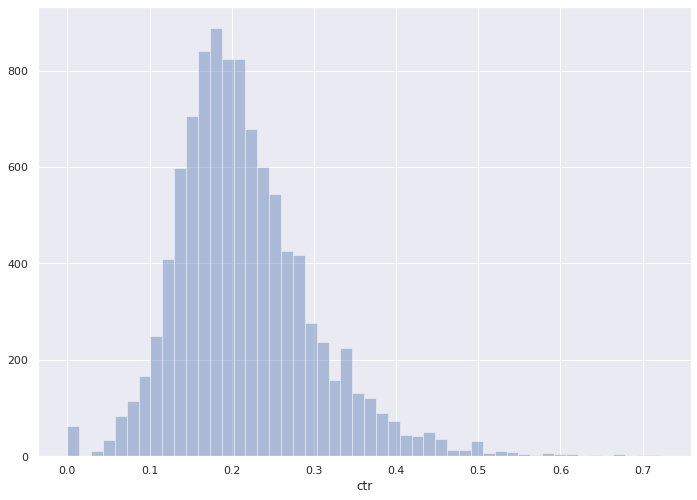

In [21]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220320.feed_actions 
WHERE toDate(time) between '2022-03-15' and  '2022-03-21' 
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
sns.distplot(group1.ctr, 
             kde = False)


<AxesSubplot:xlabel='smothed_ctr'>

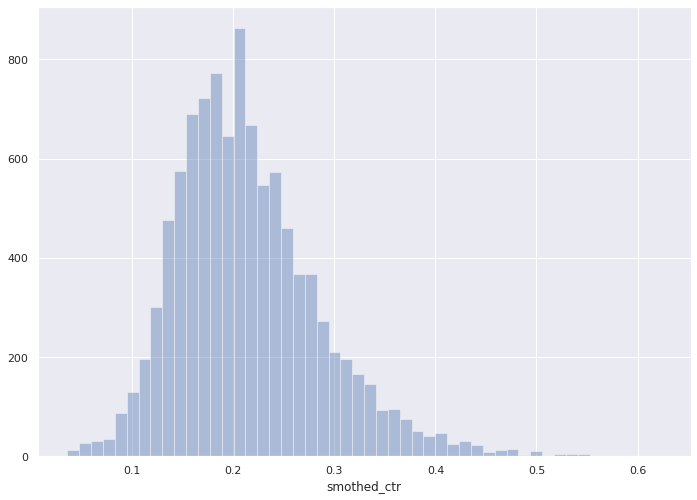

In [22]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)

<AxesSubplot:ylabel='Count'>

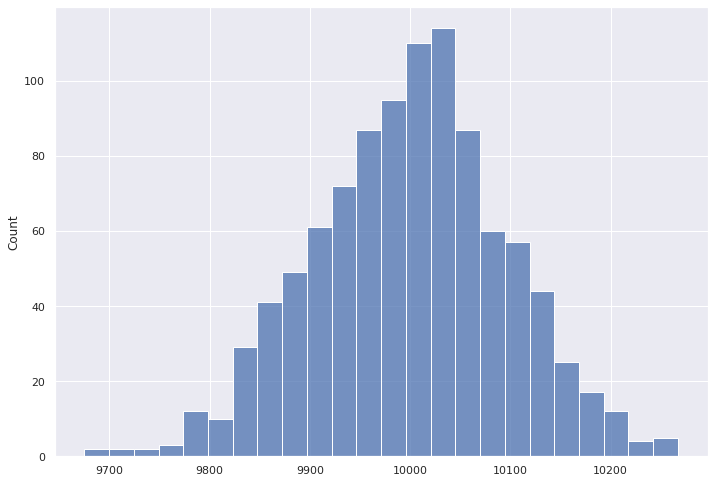

In [23]:
df = pd.DataFrame()
df['data'] = np.random.randint(1,100000,10000)

sample_length = 10000
p_to_be_taken = 1/sample_length
number_of_samples = 1000

sums = [sum(stats.binom(sample_length, 
                        p_to_be_taken).rvs(sample_length)) for _ in range(number_of_samples)]

sns.histplot(sums)

<AxesSubplot:ylabel='Count'>

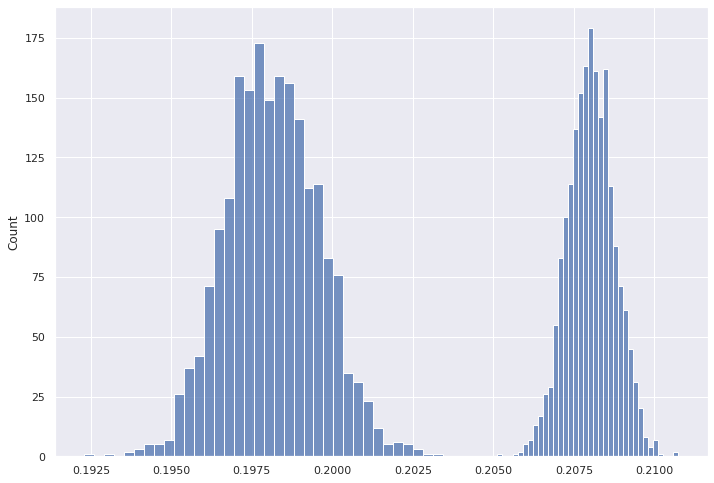

In [26]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220320.feed_actions 
WHERE toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21' 
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

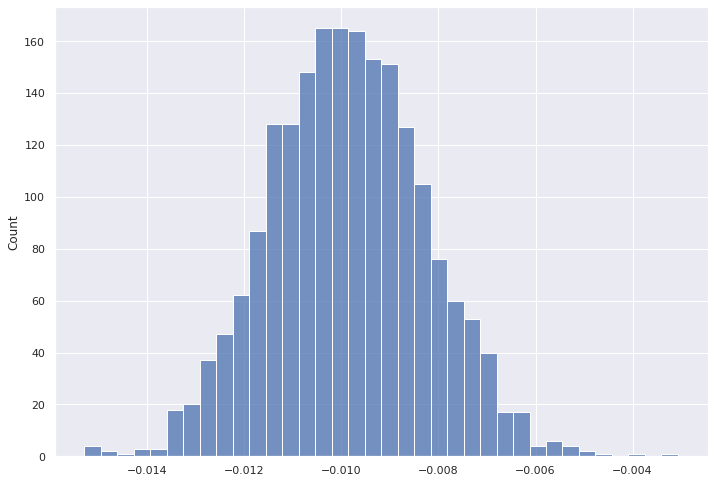

In [27]:
sns.histplot(ctr2 - ctr1)

In [30]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220320.feed_actions  
    WHERE toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21' 
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [31]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

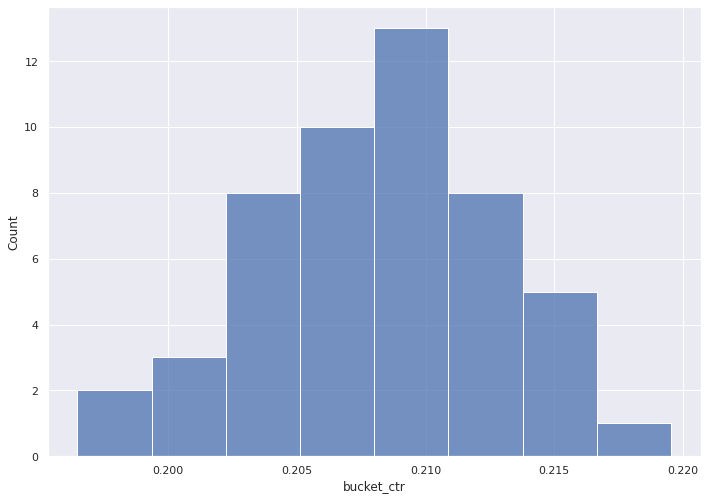

In [32]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

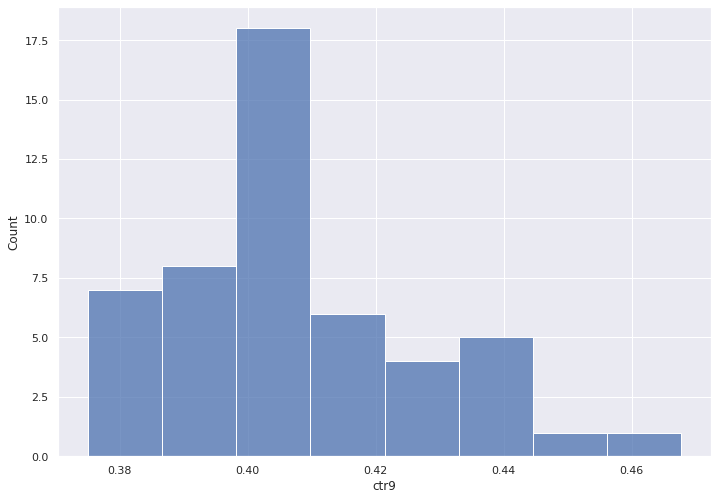

In [33]:
sns.histplot(df[df.exp_group == 2].ctr9)